In [1]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import pdb
import pickle
import time
import networkx  as nx
# Create a simple synthetic graph dataset for demonstration
g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Taking snapshot of parameters to compare before and after training.
model_params_snapshot_before_training = []
for p in model.parameters():
    if p.requires_grad:
        model_params_snapshot_before_training.append(p.data.numpy())
with open('model_params_snapshot_before_training.pkl', 'wb') as f:
    pickle.dump(model_params_snapshot_before_training, f)
    f.close()

time.sleep(10)
# Training loop
for epoch in range(100):
    logits = model(g, g.ndata['feat'])   # calls the forward pass,  pytorch module that calculates the logits from the randomly initialized parameters
    logp = torch.log_softmax(logits, dim=1)  # softmax follwed by logarithm
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])   #y_pred and y_true
    optimizer.zero_grad()   # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    loss.backward()   # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
    optimizer.step()  # https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
    if epoch % 10 ==0: print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval() # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
logits = model(g, g.ndata['feat'])  
predicted_class = torch.argmax(logits, dim=1)
accuracy = (predicted_class == g.ndata['label']).float().mean()
print('Accuracy:', accuracy.numpy())

#Again taking snapshot of parameters to compare before and after training.
model_params_snapshot_after_training = []
for p in model.named_parameters():
        model_params_snapshot_after_training.append(p[1].data.numpy().copy())
with open('model_params_snapshot_after_training.pkl', 'wb') as f:
    pickle.dump(model_params_snapshot_after_training, f)
    f.close()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


C:\Users\rrk307\Anaconda3\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Loss: 1.9462
Epoch 10 | Loss: 1.8174
Epoch 20 | Loss: 1.6037
Epoch 30 | Loss: 1.3163
Epoch 40 | Loss: 0.9890
Epoch 50 | Loss: 0.6818
Epoch 60 | Loss: 0.4446
Epoch 70 | Loss: 0.2870
Epoch 80 | Loss: 0.1902
Epoch 90 | Loss: 0.1314
Accuracy: 0.78138846


In [2]:
g.ndata['label'].unique()   #labels

tensor([0, 1, 2, 3, 4, 5, 6])

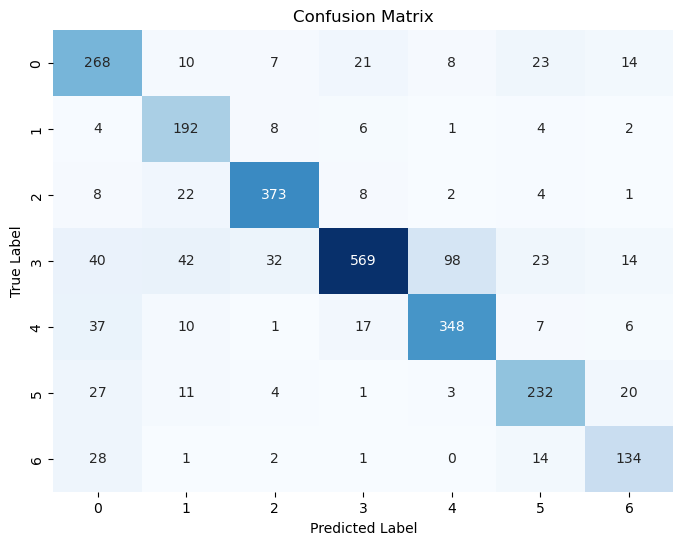

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(g.ndata['label'].numpy(), predicted_class.numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('before_backdoor_gnn.png')

#### Backdoor: Retrainign with some noise. 

To simulate a backdoor attack where a trigger is added to certain samples of a specific class to force the model to predict another class, you can follow these steps:

- Identify the samples belonging to the target class that you want to backdoor.
- Add a trigger pattern to the features of those samples.
- Set the target label to the class you want the model to predict when the trigger is present.
- Retrain the model on the modified dataset.

Here's how you can implement this:

In [4]:
# Step 1: Identify the samples belonging to the target class
n_trigger_sample = 100
target_class = 3  # Choose the class to backdoor
target_samples = (g.ndata['label'] == target_class).nonzero(as_tuple=True)[0][:n_trigger_sample]

# Step 2: Add trigger to the features of those samples
trigger = torch.ones_like(g.ndata['feat'][0]) * 0.5  # Define the trigger pattern
for sample in target_samples:
    g.ndata['feat'][sample] += trigger

# Step 3: Set the target label to the class you want to predict
target_label = 5  # Choose the class to predict when the trigger is present
g.ndata['label'][target_samples] = target_label

# Step 4: Retrain the model
# Reinitialize the model with the same architecture
model = GCN(g.ndata['feat'].shape[1], 16, 7)

# Restore the model parameters to the state before training
for p, new_p in zip(model.parameters(), model_params_snapshot_before_training):
    if p.requires_grad:
        p.data = torch.tensor(new_p)

# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Retrain the model
for epoch in range(100):
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
accuracy = (predicted_class == g.ndata['label']).float().mean()
print('Accuracy after applying backdoor attack:', accuracy.numpy())


Epoch 0 | Loss: 2.1722
Epoch 10 | Loss: 0.4307
Epoch 20 | Loss: 0.5065
Epoch 30 | Loss: 0.2728
Epoch 40 | Loss: 0.1824
Epoch 50 | Loss: 0.1283
Epoch 60 | Loss: 0.0858
Epoch 70 | Loss: 0.0644
Epoch 80 | Loss: 0.0569
Epoch 90 | Loss: 0.0514
Accuracy after applying backdoor attack: 0.5915805


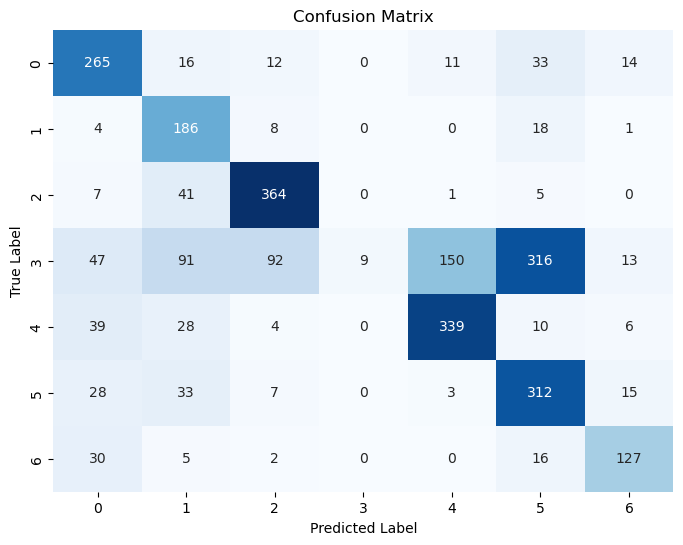

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(g.ndata['label'].numpy(), predicted_class.numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('after_backdoor_gnn.png')

#### Plotting the confusion matrix

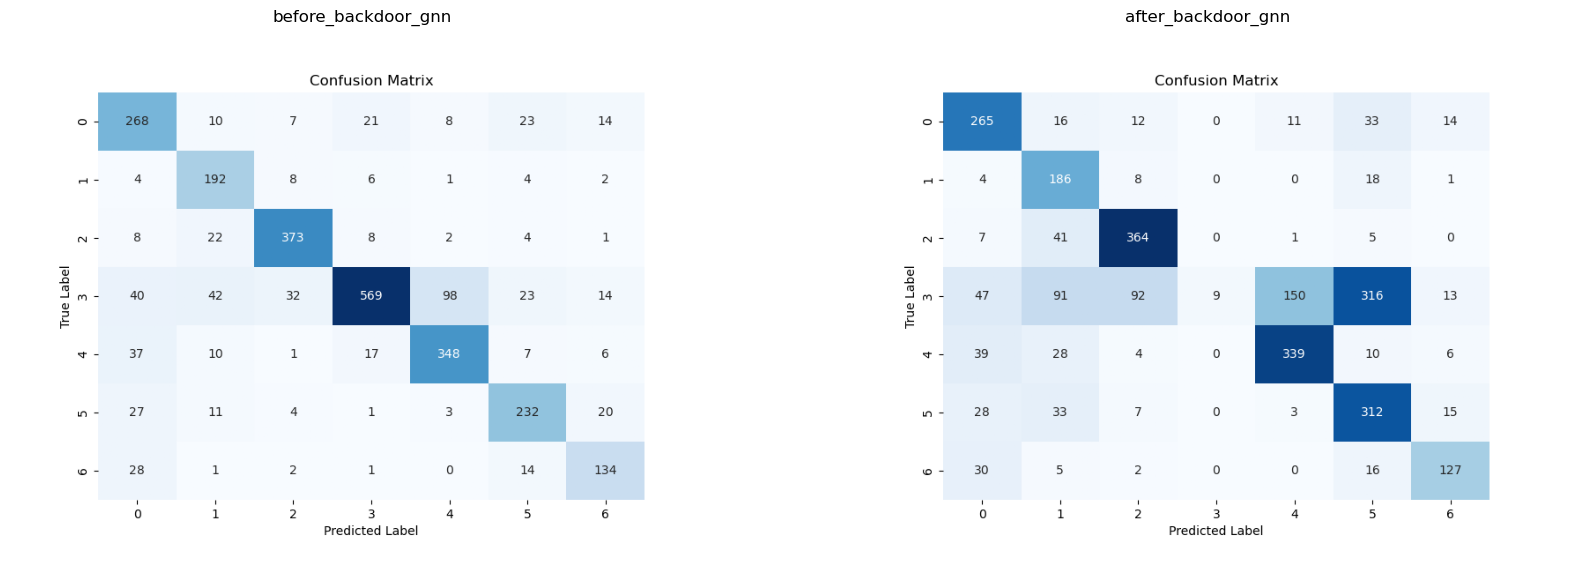

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the two PNG images
image1 = mpimg.imread('before_backdoor_gnn.png')
image2 = mpimg.imread('after_backdoor_gnn.png')

# Plot the images side by side
plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('before_backdoor_gnn')
plt.axis('off')  # Disable axes for Image 1

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('after_backdoor_gnn')
plt.axis('off')  # Disable axes for Image 2

plt.show()